# Speech Tools Minicourse, Summer 2020
## Meeting 4: pytorch

### Today's Outline
1. An example groundtruth function, with train and test data
2. Basic components of a neural net: forward, loss, backward, optimizer
3. autograd, nn, optim: automating backward, forward, and optimizer
4. Writing your own autograd function and nn module
5. Extra: random restarts, when there are too many local optima

### 1. An example groundtruth function, with train and testdata
Suppose that the input is a 2-vector, $x=[x_1,x_2]$.  The output is a three vector $y=[R,G,B]$ specifying the color of the corresponding dot.  The following function makes a grayscale spiral.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def groundtruth(X):
    '''generate intensity labels for each row of X.
    X should be an Nx2 matrix, with one vector per row.
    '''
    (N,D)=X.shape
    angle = np.arctan2(X[:,0],X[:,1])
    radius = np.linalg.norm(X,axis=1)
    Y = 0.499+0.499*np.cos(3*(angle-2*radius)).reshape((N,1))
    return(Y)
    
test_X = np.array([[0.01*x0,0.01*x1] for x0 in range(-100,101) for x1 in range(-100,101)])
print('test_X shape is %s, first sample is %s'%(str(test_X.shape),str(test_X[0,:])))
test_Y = groundtruth(test_X)
print('test_Y shape is %s, first sample is %s'%(str(test_Y.shape),str(test_Y[0,:])))


test_X shape is (40401, 2), first sample is [-1. -1.]
test_Y shape is (40401, 1), first sample is [0.00591299]


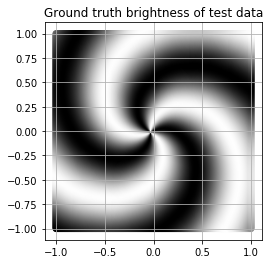

In [3]:
def showpoints(X, Y, axe, title):
    '''Scatter plot of 2D points, each with its associated brightness.
    X must be an array of size (N,2).
    Y may be an array of size (N,1), or a function.
    If Y is a function, it is applied to each row of X to determine brightness.
    '''
    (N,D)=X.shape
    axe.set_aspect('equal')
    axe.grid()
    if callable(Y):
        c = np.minimum(1,np.maximum(0,Y(X)))
    else:
        c = np.minimum(1,np.maximum(0,Y))
    axe.scatter(X[:,0],X[:,1],c=np.tile(c,(1,3)))
    axe.set_title(title)
    
(fig, axe)=plt.subplots(1,1,figsize=(4,4))
showpoints(test_X,groundtruth, axe, 'Ground truth brightness of test data')


Now let's generate some training samples, that we can use to teach the neural network about this function.

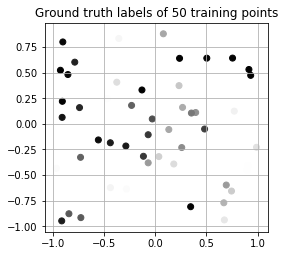

In [11]:
def generate_random_data(N):
    random_X = np.random.uniform(low=-1, high=1, size=(N,2))
    random_Y = groundtruth(random_X)
    return(random_X,random_Y)
(train_X, train_Y)=generate_random_data(50)
(fig, axe)=plt.subplots(1,1,figsize=(4,4))
showpoints(train_X,train_Y,axe,'Ground truth labels of 50 training points')

### 2. Basic components of a neural network: forward, loss, backward, optimizer

In order to write these functions, I used frequent reference to https://pytorch.org/docs/master/torch.html

In [12]:
def forward(X,w1,b1,w2,b2):
    '''Compute Yhat(X) using given weights and biases.
    X, w1, b1, etc. must be already appropriately-sized pytorch tensors.'''
    h1e = X.mm(w1)+b1
    h1a = h1e.clamp(min=0)
    Ye = h1a.mm(w2)+b2
    Ya = Ye 
    return(Ya,Ye,h1a,h1e)

In [13]:
def loss(Ya, Y):
    '''Calculate sum-squared error between Y and Yhat'''
    return((Ya-Y).pow(2).sum())

In [14]:
def backward(w1,b1,w2,b2,X,h1e,h1a,Ye,Ya,Y):
    '''Calculate derivative of loss w.r.t. each network parameter.
    In order to write this function, you need to know what the loss function is.'''
    N = Ya.size()[0]
    dLdYa = Ya-Y
    dLdYe = dLdYa.clone()
    dLdh1a = dLdYe.mm(w2.t())
    dLdh1e = dLdh1a.clone()
    dLdh1e[h1e<0] = 0
    dLdb2 = torch.sum(dLdYe,dim=0)
    dLdw2 = h1a.t().mm(dLdYe)
    dLdb1 = torch.sum(dLdh1e,dim=0)
    dLdw1 = X.t().mm(dLdh1e)
    return(dLdw1,dLdb1,dLdw2,dLdb2)

In [15]:
def optimizer(w1,b1,w2,b2,dLdw1,dLdb1,dLdw2,dLdb2,learning_rate):
    '''Update network parameters using gradient descent'''
    neww1 = w1 - learning_rate*dLdw1
    newb1 = b1 - learning_rate*dLdb1
    neww2 = w2 - learning_rate*dLdw2
    newb2 = b2 - learning_rate*dLdb2
    return(neww1,newb1,neww2,newb2)


Let's test it.  Let's generate random initial model parameters, plot the resulting function on the test data, then train for 500 epochs, and plot the resulting function.

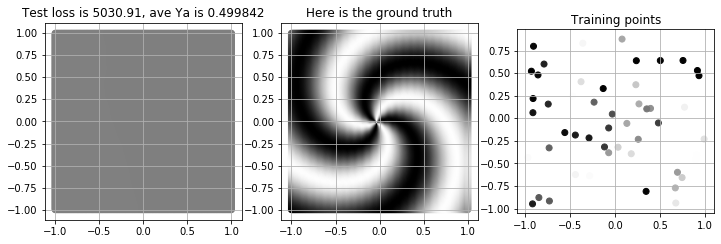

In [16]:
dt = torch.float
dev = torch.device("cpu")
w1init = torch.normal(mean=0.0,std=0.01,size=(2,80),dtype=dt,device=dev)
b1init = torch.normal(mean=0.0,std=0.01,size=(1,80),dtype=dt,device=dev)
w2init = torch.normal(mean=0.0,std=0.01,size=(80,1),dtype=dt,device=dev)
b2init = torch.tensor([0.5],dtype=dt,device=dev)
teX = torch.tensor(test_X,dtype=dt,device=dev)
teY = torch.tensor(test_Y,dtype=dt,device=dev)
trX = torch.tensor(train_X,dtype=dt,device=dev)
trY = torch.tensor(train_Y,dtype=dt,device=dev)
Ya,Ye,h1a,h1e = forward(teX,w1init,b1init,w2init,b2init)
L = loss(Ya,teY)
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
showpoints(test_X,Ya.numpy(),ax1,'Test loss is %g, ave Ya is %g'%(L.item(),Ya.mean().item()))
showpoints(test_X,groundtruth,ax2,'Here is the ground truth')
showpoints(train_X,train_Y,ax3,'Training points')

Epoch 0, loss 6.90875
Epoch 100, loss 5.50087
Epoch 200, loss 5.24345
Epoch 300, loss 5.09706
Epoch 400, loss 4.96011
Epoch 500, loss 4.69178
Epoch 600, loss 4.48175
Epoch 700, loss 4.26729
Epoch 800, loss 4.08221
Epoch 900, loss 3.89172
Epoch 1000, loss 3.668
Epoch 1100, loss 3.39867
Epoch 1200, loss 3.95742
Epoch 1300, loss 3.87573
Epoch 1400, loss 3.97981
Epoch 1500, loss 3.80459
Epoch 1600, loss 3.824
Epoch 1700, loss 3.74037
Epoch 1800, loss 3.68354
Epoch 1900, loss 3.71439


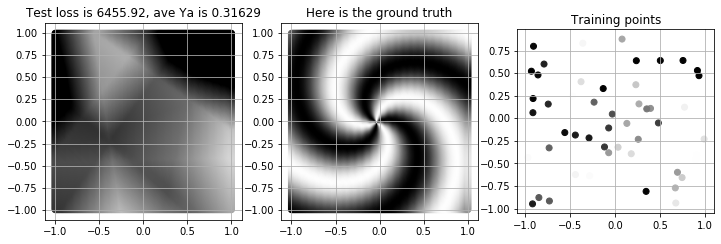

In [17]:
w1,b1,w2,b2 = w1init.clone(),b1init.clone(),w2init.clone(),b2init.clone()
for epoch in range(2000):
    Ya,Ye,h1a,h1e = forward(trX,w1,b1,w2,b2)
    L = loss(Ya,trY)
    dLdw1,dLdb1,dLdw2,dLdb2 = backward(w1,b1,w2,b2,trX,h1e,h1a,Ye,Ya,trY)
    w1,b1,w2,b2 = optimizer(w1,b1,w2,b2,dLdw1,dLdb1,dLdw2,dLdb2,1e-2)
    if epoch % 100 == 0:
        print('Epoch %d, loss %g'%(epoch,L.item()))
Ya,Ye,h1a,h1e = forward(teX,w1,b1,w2,b2)
L = loss(Ya,teY)
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
showpoints(test_X,Ya.numpy(),ax1,'Test loss is %g, ave Ya is %g'%(L.item(),Ya.mean().item()))
showpoints(test_X,groundtruth,ax2,'Here is the ground truth')
showpoints(train_X,train_Y,ax3,'Training points')

### 3. autograd, nn, optim: automating backward, forward, and optimizer

#### 3a. autograd: automatic calculation of derivatives

If you need to calculate the gradient of the loss with respect to some tensor, you just set its requires_grad attribute to True.

In [18]:
w1init = torch.normal(mean=0.0,std=0.01,size=(2,80),dtype=dt,device=dev,requires_grad=True)
b1init = torch.normal(mean=0.0,std=0.01,size=(1,80),dtype=dt,device=dev,requires_grad=True)
w2init = torch.normal(mean=0.0,std=0.01,size=(80,1),dtype=dt,device=dev,requires_grad=True)
b2init = torch.tensor([0.5],dtype=dt,device=dev,requires_grad=True)


With that simple change, now we can revise forward() and backward() to throw away all intermediate values.  They are not really discarded --- Ya and L keep pointers backward to the variables that computed them, and the resulting gradients, like dLdb1, are now stored in the .grad attribute of the corresponding tensor (b1.grad).

The cost of doing this is in the optimizer function.  When we create a new variable, newb1, to replace the old b1, we have to make sure to set _its_ requires_grad attribute, as shown.   Or, if we re-used the same b1 variable, we'd have to zero out its gradient, as shown at https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

In [19]:
def forward(X,w1,b1,w2,b2):
    '''Compute Yhat(X) using given weights and biases.
    X, w1, b1, etc. must be already appropriately-sized pytorch tensors.'''
    Ya = (X.mm(w1)+b1).clamp(min=0).mm(w2)+b2
    return(Ya)

def loss(Ya, Y):
    '''Calculate sum-squared error between Y and Yhat'''
    return((Ya-Y).pow(2).sum())

def backward(L):
    L.backward()

def optimizer(w1,b1,w2,b2,learning_rate):
    '''Update network parameters using gradient descent,
    using their built-in grad attributes.
    We have to wrap this in torch.no_grad(), because
    we dont want THIS operation to be tracked for later autograd updates.'''
    with torch.no_grad():
        neww1 = w1 - learning_rate*w1.grad
        neww1.requires_grad_()
        newb1 = b1 - learning_rate*b1.grad
        newb1.requires_grad_()
        neww2 = w2 - learning_rate*w2.grad
        neww2.requires_grad_()
        newb2 = b2 - learning_rate*b2.grad
        newb2.requires_grad_()
    return(neww1,newb1,neww2,newb2)


Now we just run the optimization again, using these new, simpler backward and optimizer functions.

0 6.908375263214111
200 4.851213455200195
400 4.366462707519531
600 4.431059837341309
800 4.249878406524658
1000 4.061061382293701
1200 3.822765827178955
1400 3.5370795726776123
1600 3.433791160583496
1800 3.1685101985931396


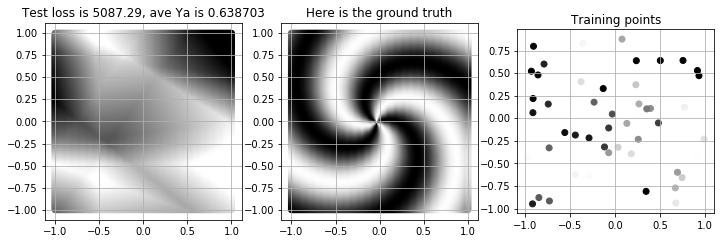

In [20]:
w1 = torch.normal(mean=0.0,std=0.01,size=(2,80),dtype=dt,device=dev,requires_grad=True)
b1 = torch.normal(mean=0.0,std=0.01,size=(1,80),dtype=dt,device=dev,requires_grad=True)
w2 = torch.normal(mean=0.0,std=0.01,size=(80,1),dtype=dt,device=dev,requires_grad=True)
b2 = torch.tensor([0.5],dtype=dt,device=dev,requires_grad=True)
for epoch in range(2000):
    Ya = forward(trX,w1,b1,w2,b2)
    L = loss(Ya,trY)
    if epoch % 200 == 0:
        print(epoch,L.item())
    backward(L)
    w1,b1,w2,b2 = optimizer(w1,b1,w2,b2,1e-2)
Ya = forward(teX,w1,b1,w2,b2)
L = loss(Ya,teY)
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
showpoints(test_X,Ya.detach().numpy(),ax1,'Test loss is %g, ave Ya is %g'%(L.item(),Ya.mean().item()))
showpoints(test_X,groundtruth,ax2,'Here is the ground truth')
showpoints(train_X,train_Y,ax3,'Training points')

#### 3b. nn: automatic generation of all the model parameters

The requires_grad feature allowed us to stop keeping track of the various gradients (dLdb1) and hidden node excitations (h1e) and activations (h1a).  Those things are kept in a hidden computation graph, connecting between the variable on which you call the backward() function (L), and the variable that has attribute requires_grad.

Similarly, the nn module allows you to stop keeping track of w1, b1, w2, and b2.  Instead, they get summarized into a list called model.parameters().

This is done by replacing the forward() function with a model() object:

In [21]:
def initialize_weights(m):
    if type(m)==torch.nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0.0,std=0.01)
        torch.nn.init.normal_(m.bias,mean=0.0,std=0.01)

model = torch.nn.Sequential(
    torch.nn.Linear(2,80,bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(80,1,bias=True)
)
model.apply(initialize_weights)

def loss(Ya, Y):
    '''Calculate sum-squared error between Y and Yhat'''
    return((Ya-Y).pow(2).sum())

def backward(L):
    L.backward()

def optimizer(model,learning_rate):
    '''Update network parameters using gradient descent,
    using their built-in grad attributes.
    We have to wrap this in torch.no_grad(), because
    we dont want THIS operation to be tracked for later autograd updates.'''
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    model.zero_grad()


0 17.028766632080078
200 5.031911849975586
400 4.255311965942383
600 4.361302375793457
800 4.267728328704834
1000 4.114658355712891
1200 4.08727502822876
1400 4.009254455566406
1600 3.7936713695526123
1800 3.7279574871063232


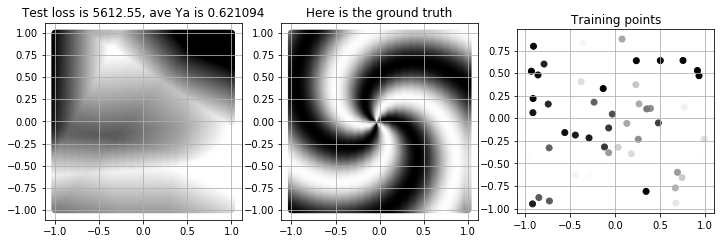

In [22]:
for epoch in range(2000):
    Ya = model(trX)
    L = loss(Ya,trY)
    if epoch % 200 == 0:
        print(epoch,L.item())
    backward(L)
    optimizer(model,1e-2)
Ya = model(teX)
L = loss(Ya,teY)
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
showpoints(test_X,Ya.detach().numpy(),ax1,'Test loss is %g, ave Ya is %g'%(L.item(),Ya.mean().item()))
showpoints(test_X,groundtruth,ax2,'Here is the ground truth')
showpoints(train_X,train_Y,ax3,'Training points')

The functionality of the nn module changes extremely rapidly.  Standard documentation is here: https://pytorch.org/docs/stable/nn.html

#### 3c. optim: automatic optimization

OK!  Now that the autograd feature wrote our backward() for us, and the nn module wrote our forward() for us, let's use the optimizer module to write our optimizer() for us.

In [23]:
def initialize_weights(m):
    if type(m)==torch.nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0.0,std=0.01)
        torch.nn.init.normal_(m.bias,mean=0.0,std=0.01)

model = torch.nn.Sequential(
    torch.nn.Linear(2,80,bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(80,1,bias=True)
)
model.apply(initialize_weights)

def loss(Ya, Y):
    '''Calculate sum-squared error between Y and Yhat'''
    return((Ya-Y).pow(2).sum())

def backward(L):
    L.backward()

# SGD = stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)


0 16.88372802734375
200 4.950965404510498
400 4.618865966796875
600 4.425031661987305
800 4.239086151123047
1000 4.027192115783691
1200 4.0149335861206055
1400 3.743180990219116
1600 3.5500898361206055
1800 3.374770402908325
2000 3.1483864784240723
2200 3.126502752304077
2400 3.1758835315704346
2600 3.085731267929077
2800 2.969771385192871


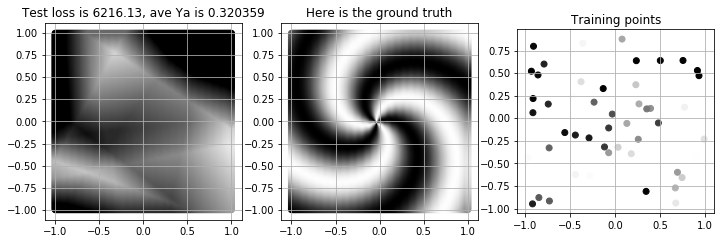

In [24]:
for epoch in range(3000):
    Ya = model(trX)
    L = loss(Ya,trY)
    if epoch % 200 == 0:
        print(epoch,L.item())
    optimizer.zero_grad()
    backward(L)
    optimizer.step()
Ya = model(teX)
L = loss(Ya,teY)
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
showpoints(test_X,Ya.detach().numpy(),ax1,'Test loss is %g, ave Ya is %g'%(L.item(),Ya.mean().item()))
showpoints(test_X,groundtruth,ax2,'Here is the ground truth')
showpoints(train_X,train_Y,ax3,'Training points')

### 4. Writing your own autograd function and nn module

You might have noticed that a two-layer network with ReLU nonlinearities isn't working very well.  In this case, we know that we can solve the problem with _zero_ error if we can create a three-layer network in which the first hidden layer calculates atan2 and norm, the second layer does a linear transform followed by cosine, and the third layer is another linear layer. 

First, let's create custom autograd functions for cosine.

Then, we'll create a custom nn module with the torch.atan2 and torch.norm functions, and with your custom AutogradCosine function, in an attempt to create a perfect solution to this problem.

A custom autograd module needs two methods:
1. forward(ctx, input): generates an output tensor from the input.  This one is applied, during computation, by calling MyClass.apply(input).  Any context you want to save, for later use in backward, gets saved in ctx.
2. backward(ctx, grad_output): given gradient of the loss with respect to the output, compute and return the gradient of the loss with respect to the input.

In [85]:
class MyCosine(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = torch.cos(input)
        return(output)
    @staticmethod
    def backward(ctx, dLdoutput):
        input, = ctx.saved_tensors
        raise NotImplementedError("Write this code: if output=cos(input), and we know dL/doutput, what is dL/dinput?")
        return(dLdinput)

Now let's create a custom network, incorporating atan2, norm, and the MyCosine function.

In [86]:
class MyNetwork(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(MyNetwork, self).__init__()
        self.linear1 = torch.nn.Linear(2, 1, bias=False)
        torch.nn.init.normal_(self.linear1.weight,mean=0.0,std=0.01)
        print('-- linear1 weight is ',self.linear1.weight)
        self.linear2 = torch.nn.Linear(1, 1, bias=True)
        torch.nn.init.normal_(self.linear2.weight,mean=0.0,std=0.01)
        print('-- linear2 weight is ',self.linear2.weight)
        torch.nn.init.normal_(self.linear2.bias,mean=0.0,std=0.01)
        print('-- linear2 bias is ',self.linear2.bias)

    def forward(self, X):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h1atan = torch.atan2(X[:,0],X[:,1]).unsqueeze(1)
        h1norm = torch.norm(X,dim=1).unsqueeze(1)
        h1 = torch.cat((h1atan,h1norm),1)
        h2 = MyCosine.apply(self.linear1(h1))
        y_pred = self.linear2(h2)
        return(y_pred)

model = MyNetwork()
loss = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

-- linear1 weight is  Parameter containing:
tensor([[ 0.0100, -0.0154]], requires_grad=True)
-- linear2 weight is  Parameter containing:
tensor([[0.0162]], requires_grad=True)
-- linear2 bias is  Parameter containing:
tensor([-0.0019], requires_grad=True)


In [88]:
for epoch in range(3000):
    Ya = model(trX)
    L = loss(Ya,trY)
    if epoch % 500 == 0:
        print(epoch,L.item())
    optimizer.zero_grad()
    backward(L)
    optimizer.step()
    
print('Parameters are now:',', '.join([str(p.data) for p in model.parameters()]))
Ya = model(teX)
L = loss(Ya,teY)
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
showpoints(test_X,Ya.detach().numpy(),ax1,'Test loss is %g, ave Ya is %g'%(L.item(),Ya.mean().item()))
showpoints(test_X,groundtruth,ax2,'Here is the ground truth')
showpoints(train_X,train_Y,ax3,'Training points')

0 16.31901741027832


RuntimeError: Write this code: if output=cos(input), and we know dL/doutput, what is dL/dinput?

### 5. Extra: random restarts, when there are too many local optima

It has the right general shape now, but it's converged to a set of parameters that are not very good.  Let's try random restarts, with the first weight sat randomly in the range $w\in[-8,8]$, and the second weight and bias set randomly in $w,b\in[0,1]$.

--- Restart 0 achieved loss 6.32219
Starting params: tensor([[3.6957, 6.7455]]), tensor([[0.9214]]), tensor([0.0204])
Optimized params: tensor([[3.4744, 6.2585]]), tensor([[0.1373]]), tensor([0.4372])
--- Restart 1 achieved loss 5.82951
Starting params: tensor([[-2.0720, -1.1570]]), tensor([[0.1215]]), tensor([0.7678])
Optimized params: tensor([[-2.5095, -0.8008]]), tensor([[0.2035]]), tensor([0.4341])
--- Restart 11 achieved loss 2.34762e-09
Starting params: tensor([[-1.8500,  5.4098]]), tensor([[0.9541]]), tensor([0.5039])
Optimized params: tensor([[-3.0000,  6.0000]]), tensor([[0.4990]]), tensor([0.4990])
--- Restart 18 achieved loss 6.22568e-10
Starting params: tensor([[ 3.6321, -5.0658]]), tensor([[0.1245]]), tensor([0.1862])
Optimized params: tensor([[ 3.0000, -6.0000]]), tensor([[0.4990]]), tensor([0.4990])


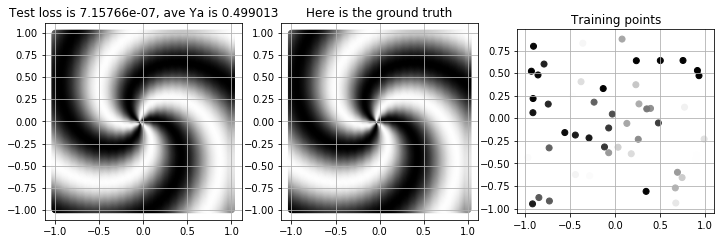

In [82]:
best_loss = np.Infinity
for restart in range(30):
    torch.nn.init.uniform_(model.linear1.weight,a=-8,b=8)
    torch.nn.init.uniform_(model.linear2.weight,a=0,b=1)
    torch.nn.init.uniform_(model.linear2.bias,a=0,b=1)
    starting_params = [ p.data.clone() for p in model.parameters() ]
    for epoch in range(200):
        L=loss(model(trX), trY)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
    if L.item() < best_loss:
        best_loss = L.item()
        best_params = [ p.data.clone() for p in model.parameters() ]
        best_restart = restart
        print('--- Restart %d achieved loss %g'%(best_restart,best_loss))
        print('Starting params:',', '.join([ str(p) for p in starting_params ]))
        print('Optimized params:',', '.join([ str(p) for p in best_params ]))

model.linear1.weight.data = best_params[0]
model.linear2.weight.data = best_params[1]
model.linear2.bias.data = best_params[2]
Ya = model(teX)
L = loss(Ya,teY)
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
showpoints(test_X,Ya.detach().numpy(),ax1,'Test loss is %g, ave Ya is %g'%(L.item(),Ya.mean().item()))
showpoints(test_X,groundtruth,ax2,'Here is the ground truth')
showpoints(train_X,train_Y,ax3,'Training points')

### Conclusion

Well, that's all for today.  At the end, we really cheated: we told the neural net exactly what structure it should learn, and over what range it should search for parameters.  Given those specifications, it was able to find the perfect parameters!  